# 📘 Pneumonia vs Normal – CNN Classification Report

This notebook performs end-to-end training of a Convolutional Neural Network (CNN) to classify chest X-ray images as **Normal** or **Pneumonia**.  
The workflow includes dataset preparation, preprocessing, model building, training, evaluation, and visualization.


## 🔧 1. Environment Setup

The notebook begins by importing required libraries:

- os, random, numpy  
- tensorflow  
- matplotlib.pyplot  

Core training parameters are defined, including:

- Image size  
- Batch size  
- Number of epochs  
- AUTOTUNE for data pipeline optimization

Dataset directory paths for training, validation, and testing are also configured.


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Display plots inside notebook
%matplotlib inline

SEED = 42
BATCH_SIZE = 16
IMG_SIZE = (128, 128)
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

# Fix randomness
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset paths
ROOT = r".\chest_xray"
TRAIN_DIR = ROOT + r"\train"
VAL_DIR   = ROOT + r"\val"
TEST_DIR  = ROOT + r"\test"
                       

## 📂 2. Dataset Verification

A helper function is used to inspect the dataset folders and print how many images belong to each class:

- NORMAL  
- PNEUMONIA  

Counts are displayed for:

- Training set  
- Validation set  
- Test set  

This confirms that the dataset is properly structured before training.


In [9]:
# Verify dataset folders and counts

def list_images(directory):
    exts = (".jpg", ".jpeg", ".png")
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(exts)]

for split in ["train", "val", "test"]:
    split_path = os.path.join(ROOT, split)
    print("\nChecking:", split_path)
    
    for cls in ["NORMAL", "PNEUMONIA"]:
        cls_path = os.path.join(split_path, cls)
        if os.path.exists(cls_path):
            print(f" - {cls}: {len(os.listdir(cls_path))} images")
        else:
            print(f" - {cls}: ❌ Missing")



Checking: .\chest_xray\train
 - NORMAL: 1266 images
 - PNEUMONIA: 3418 images

Checking: .\chest_xray\val
 - NORMAL: 158 images
 - PNEUMONIA: 427 images

Checking: .\chest_xray\test
 - NORMAL: 159 images
 - PNEUMONIA: 428 images


## 🗂️ 3. TensorFlow Data Pipeline

A custom function `make_dataset()` builds an optimized `tf.data` pipeline.

The pipeline performs:
- Reading file paths  
- Assigning labels  
- Decoding and resizing images  
- Normalizing pixel values  
- Shuffling (only for training)  
- Batching  
- Prefetching for speed  

The function outputs:
- A fully prepared `tf.data.Dataset`  
- The number of images in the dataset  

Datasets created:
- train_ds  
- val_ds  
- test_ds  

In [10]:
# Create datasets using tf.data

def make_dataset(directory, batch_size, training=False):

    normal_dir = os.path.join(directory, "NORMAL")
    pneumonia_dir = os.path.join(directory, "PNEUMONIA")

    normal_files = list_images(normal_dir)
    pneumonia_files = list_images(pneumonia_dir)

    files = normal_files + pneumonia_files
    labels = ([0] * len(normal_files)) + ([1] * len(pneumonia_files))

    ds = tf.data.Dataset.from_tensor_slices((files, labels))

    # Shuffle only when training
    if training and len(files) > 0:
        ds = ds.shuffle(buffer_size=len(files), seed=SEED)

    # Load & preprocess images
    def load_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label

    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)

    # Augmentation
    if training:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds, len(files)


## 🧠 4. Convolutional Neural Network Model

The function `build_model()` constructs a CNN classifier with:

- Conv2D layers  
- BatchNormalization  
- MaxPooling  
- Flattening layer  
- Dense layers  
- Softmax output layer for two-class prediction  

The model is compiled and made ready for training.


In [11]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,265 (32.36 MB)

 Trainable params: 8,482,817 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
train_ds, n_train = make_dataset(TRAIN_DIR, BATCH_SIZE, training=True)
val_ds, n_val = make_dataset(VAL_DIR, BATCH_SIZE, training=False)
test_ds, n_test = make_dataset(TEST_DIR, BATCH_SIZE, training=False)

print("Train Images:", n_train)
print("Val Images:", n_val)
print("Test Images:", n_test)


Train Images: 4684
Val Images: 585
Test Images: 587


## 🛠️ 5. Training Callbacks

Two callbacks are configured to improve training:

### ✔ ModelCheckpoint
Saves the best-performing model to `best_model.keras`.

### ✔ ReduceLROnPlateau
Automatically reduces the learning rate when validation loss stops improving.


In [13]:
cb = [
    callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3)
]


## 📈 6. Model Training

The model is trained using:

- train_ds as input  
- val_ds for validation  
- Defined number of epochs  
- The configured callbacks  

Training progress (loss and accuracy) is stored in the `history` object.


In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=cb
)


Epoch 1/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 72s 239ms/step - accuracy: 0.8792 - loss: 0.3666 - val_accuracy: 0.7299 - val_loss: 6.9492 - learning_rate: 1.0000e-04
Epoch 2/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 68s 233ms/step - accuracy: 0.9137 - loss: 0.2199 - val_accuracy: 0.9009 - val_loss: 0.2510 - learning_rate: 1.0000e-04
Epoch 3/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 70s 238ms/step - accuracy: 0.9257 - loss: 0.1920 - val_accuracy: 0.8855 - val_loss: 0.3161 - learning_rate: 1.0000e-04
Epoch 4/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 70s 239ms/step - accuracy: 0.9332 - loss: 0.1739 - val_accuracy: 0.8957 - val_loss: 0.2647 - learning_rate: 1.0000e-04
Epoch 5/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 74s 253ms/step - accuracy: 0.9360 - loss: 0.1733 - val_accuracy: 0.8838 - val_loss: 0.3318 - learning_rate: 1.0000e-04
Epoch 6/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.9426 - loss: 0.1524 - val_accuracy: 0.9504 - val_loss: 0.1539 - learning_rate: 3.0000e-05
Epoch 7/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 68s 23

## 📊 7. Training Performance Visualization

The notebook generates plots showing:

- Training vs Validation Accuracy  
- Training vs Validation Loss  

These graphs help analyze the model’s learning behavior and detect under/overfitting.


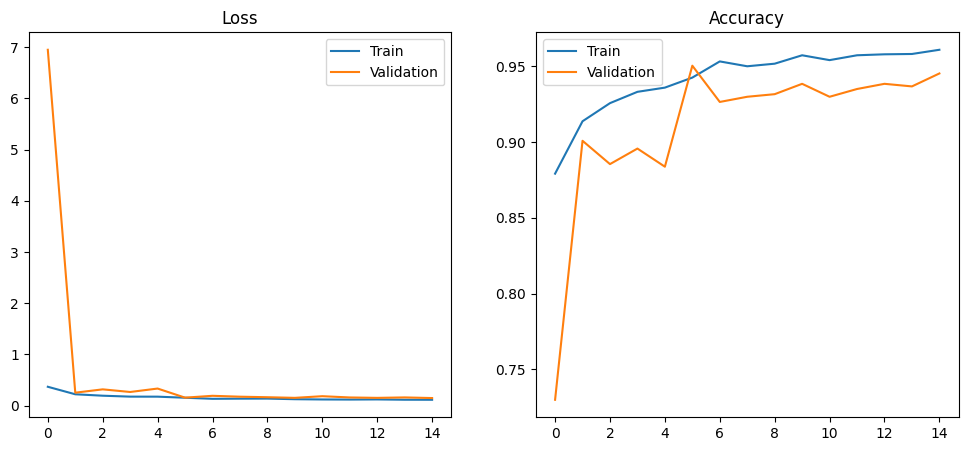

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train','Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train','Validation'])

plt.show()


## 🧪 8. Model Evaluation

The model is evaluated on the test dataset.  
The notebook prints:

- Test loss  
- Test accuracy  

This represents final model performance on unseen data.


In [16]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9489 - loss: 0.1366

Test Accuracy: 0.9489


## 🧾 9. Confusion Matrix

The notebook computes predictions on the test dataset and generates a confusion matrix.

It visualizes classification performance for:

- Normal  
- Pneumonia  

This helps identify misclassifications and class-specific behavior.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

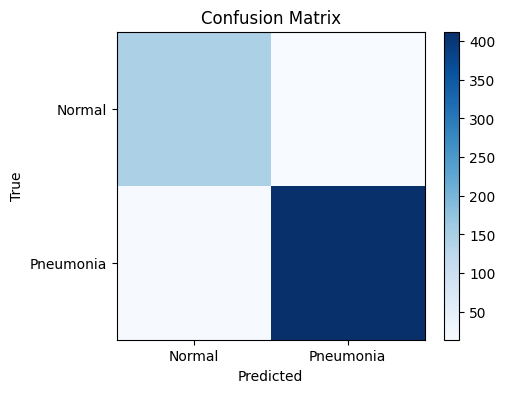

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Normal", "Pneumonia"])
plt.yticks([0,1], ["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
